DESAFIO 07

**Crie um modelo de análise das métricas RFV**

*Os dados fornecidos possuem informações de transações de compras de uma loja de
e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.*

**Breve descrição**

| Coluna      | Descrição                           |
|-------------|-------------------------------------|
| InvoiceNo   | Identificação da transação          |
| StockCode   | Código de estoque do produto        |
| Description | Descrição do produto                |
| Quantity    | Quantidade de produtos por transação|
| InvoiceDate | Data da transação                   |
| UnitPrice   | Preço unitário do produto           |
| CustomerID  | Identificação do cliente            |
| Country     | País de origem da transação         |



##Imports

In [1]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Modeling
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, k_means, dbscan
from sklearn.preprocessing import PowerTransformer

#Métricas
from yellowbrick.cluster import kelbow_visualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


#EDA e Pré-Processamento

In [2]:
df = pd.read_csv('data.csv',encoding='unicode_escape')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info() #Percebe-se a presença de dados faltantes, bem como colunas com tipos errados, vou analisar com mais cautela

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
'''
A coluna CustomerID possui muitos valores nulos, o que poderia ser um indicativo para removê-la.
Entretanto, em uma análise de RFV, uma das métricas mais importantes é justamente o CustomerID.
Dessa forma, iremos manter essa coluna, e retirar apenas as linhas nas quais esse valor é nulo.
Infelizmente não consegui pensar em outro tratamento a não ser a exclusão, por isso tomei essa
medida que normalmente não é recomendável, mas nesse caso em específico é o que cabe
'''
df.isna().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df = df.dropna(axis = 0, how = 'any', subset = 'CustomerID')

In [7]:
'''
Ao remover os valores nulos relacionados ao CustomerID, coincidentemente removeu-se todos os
dados faltantes do dataframe, então podemos continuar a analise
'''
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
df.duplicated().sum() #Percebe-se que há existencia de dados duplicados, vamos ver se isso faz sentido ou não

np.int64(5225)

In [9]:
df[df.duplicated(keep = False)].sort_values(['InvoiceNo','StockCode']) # Da pra visualizar realmente a existência de varios dados duplicados, sendo assim irei removê-los

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
440149,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,11/4/2011 13:25,2.95,15110.0,United Kingdom
461407,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,11/13/2011 11:38,0.55,17838.0,United Kingdom
461408,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,11/13/2011 11:38,0.55,17838.0,United Kingdom
529980,C580764,22667,RECIPE BOX RETROSPOT,-12,12/6/2011 10:38,2.95,14562.0,United Kingdom


In [10]:
df = df.drop_duplicates() # Dropando dados duplicados

In [11]:
df.describe() # Com essa função, da pra perceber inconsistências na quantidade negativa e tambem no preço unitario sendo 0, irei dropar esses dados inconsistentes

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [12]:
df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)] # Dropei os dados

In [13]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [14]:
df.nunique() # Vendo se tem alguma coluna possivelmente categórica

InvoiceNo      18532
StockCode       3665
Description     3877
Quantity         301
InvoiceDate    17282
UnitPrice        440
CustomerID      4338
Country           37
dtype: int64

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%m/%d/%Y %H:%M')
df['CustomerID'] =  df['CustomerID'].astype('str')

In [16]:
df.describe() # Agora ta fazendo mais sentido os dados, mas ainda falta tratar os dados outliers, para isso irei visualizá-los com gráficos, mas farei isso depois de analisar os dados

,Quantity,InvoiceDate,UnitPrice
count,392692.000000,392692,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 12:02:00,1.950000
75%,12.000000,2011-10-20 12:53:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,180.492832,NaN,22.241836


In [17]:
agg_customer_invoiceNo = df.groupby(['CustomerID','InvoiceNo','InvoiceDate']).sum().reset_index()
qtdade_compras = agg_customer_invoiceNo.groupby('CustomerID').InvoiceNo.count().reset_index().rename(columns = {'InvoiceNo':'Frequency'})
df = df.merge(qtdade_compras, how = 'left', on ='CustomerID')

In [18]:
ultima_data = df.InvoiceDate.max()
ultima_compra = df.groupby('CustomerID').InvoiceDate.max().reset_index().rename(columns = {'InvoiceDate':'LastPurchase'})

df = df.merge(ultima_compra, how = 'left', on ='CustomerID')
df['Recency'] = df['LastPurchase'].apply(lambda x: (ultima_data - x).days)
df = df.drop(columns = 'LastPurchase')

In [19]:
df['TotalPrice'] = df['UnitPrice']*df['Quantity']
df_mean_price = df.groupby('CustomerID').TotalPrice.mean().round(2).reset_index().rename(columns = {'TotalPrice':'MeanPrice'})
df = df.merge(df_mean_price, how = 'left', on ='CustomerID')

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Frequency,Recency,TotalPrice,MeanPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,34,371,15.30,18.15
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,34,371,22.00,18.15
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15


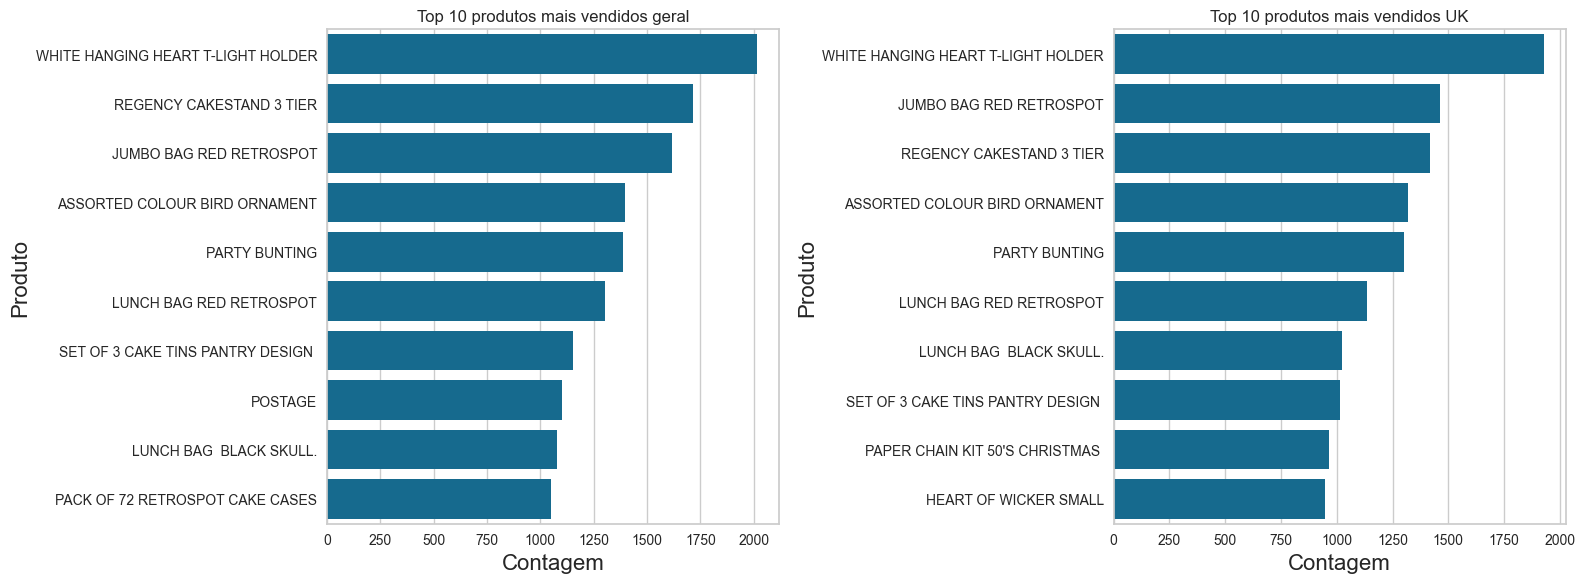

In [21]:
fig, axes = plt.subplots(ncols = 2, figsize=(16,6))
sns.barplot(df['Description'].value_counts(ascending = False)[:10], orient = 'h', ax = axes[0])
sns.barplot(df[df['Country'] == 'United Kingdom']['Description'].value_counts(ascending = False)[:10], orient = 'h', ax = axes[1])
for ax in axes:
    ax.set_xlabel('Contagem', fontsize=16)
    ax.set_ylabel('Produto', fontsize=16)
    ax.tick_params(axis='y', labelsize = 'small')
axes[0].set_title('Top 10 produtos mais vendidos geral')
axes[1].set_title('Top 10 produtos mais vendidos UK')
plt.tight_layout()

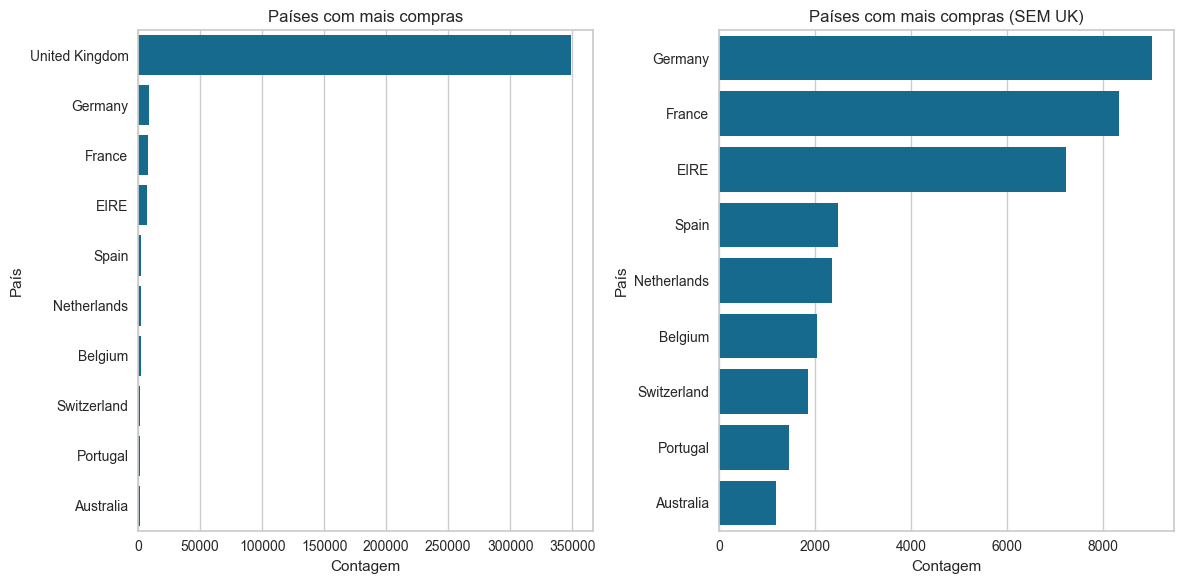

In [22]:
fig, axes = plt.subplots(ncols = 2, figsize=(12, 6))
sns.barplot(df['Country'].value_counts()[0:10], ax = axes[0], orient = 'h')
sns.barplot(df['Country'].value_counts()[1:10], ax = axes[1], orient = 'h')
for ax in axes:
    ax.set_xlabel('Contagem')
    ax.set_ylabel('País')
axes[0].set_title('Países com mais compras')
axes[1].set_title('Países com mais compras (SEM UK)')
plt.tight_layout()

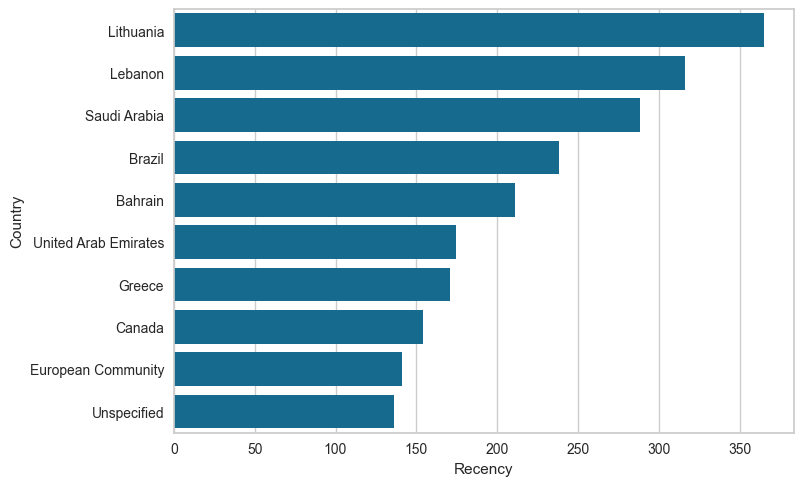

In [23]:
sns.barplot(df.groupby('Country')['Recency'].mean().sort_values(ascending = False)[0:10], orient = 'h');

In [24]:
top_10_customers = df.groupby('CustomerID').TotalPrice.sum().sort_values(ascending = False)[0:10]
(
df[df['CustomerID'].isin(top_10_customers.index)]
.groupby(['CustomerID','Country'])
.TotalPrice
.sum()
.sort_values(ascending = False)
) # Aqui percebemos que a maioria dos compradores que mais gastam está na inglaterra, mas não é regra.

CustomerID  Country       
14646.0     Netherlands       280206.02
18102.0     United Kingdom    259657.30
17450.0     United Kingdom    194390.79
16446.0     United Kingdom    168472.50
14911.0     EIRE              143711.17
12415.0     Australia         124914.53
14156.0     EIRE              117210.08
17511.0     United Kingdom     91062.38
16029.0     United Kingdom     80850.84
12346.0     United Kingdom     77183.60
Name: TotalPrice, dtype: float64

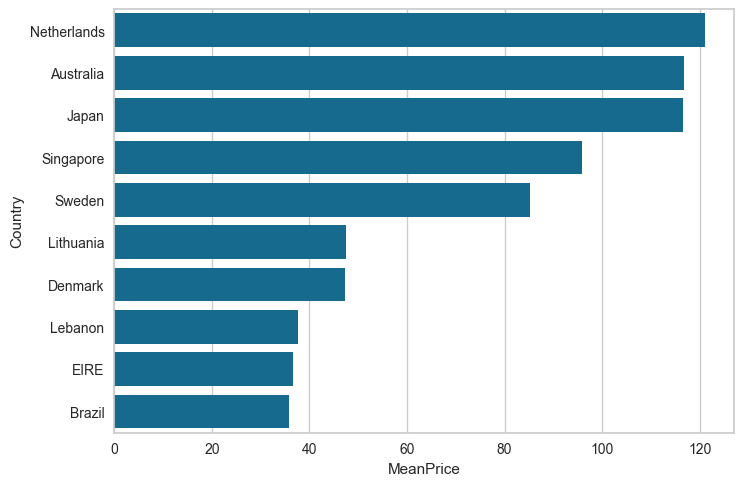

In [25]:
'''
Aqui percebemos algo interessante, os países que mais compram não necessariamente são os que possuem maior preço médio
'''
sns.barplot(df.groupby('Country').MeanPrice.mean().sort_values(ascending = False)[0:10], orient = 'h');

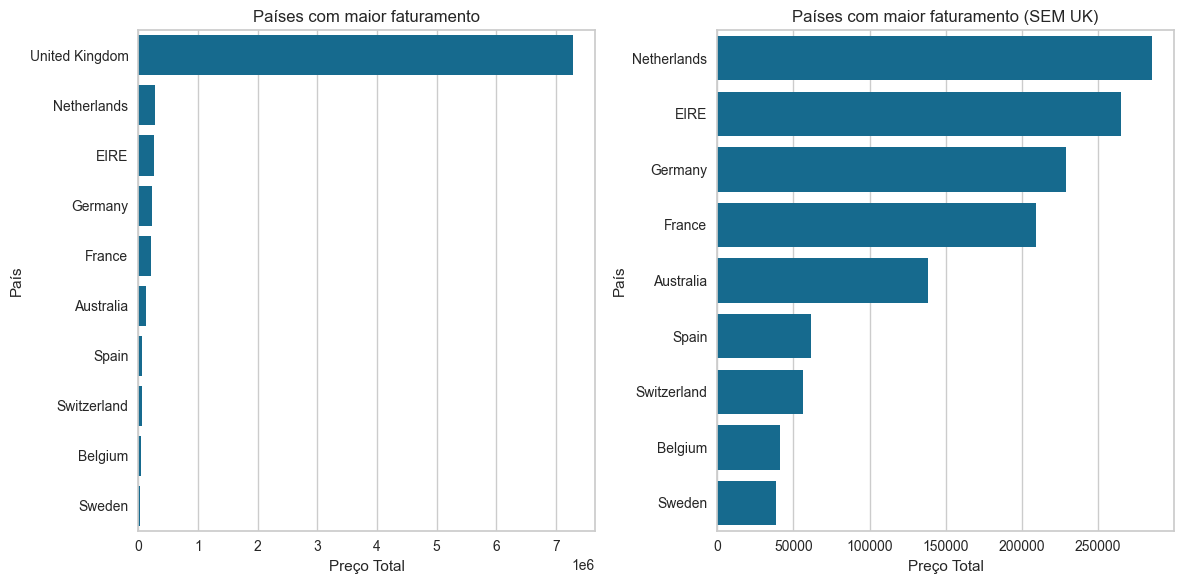

In [26]:
fig, axes = plt.subplots(ncols = 2, figsize=(12, 6))
sns.barplot(df.groupby('Country').TotalPrice.sum().sort_values(ascending = False)[0:10], ax = axes[0], orient = 'h')
sns.barplot(df.groupby('Country').TotalPrice.sum().sort_values(ascending = False)[1:10], ax = axes[1], orient = 'h')
for ax in axes:
    ax.set_xlabel('Preço Total')
    ax.set_ylabel('País')
axes[0].set_title('Países com maior faturamento')
axes[1].set_title('Países com maior faturamento (SEM UK)')
plt.tight_layout()

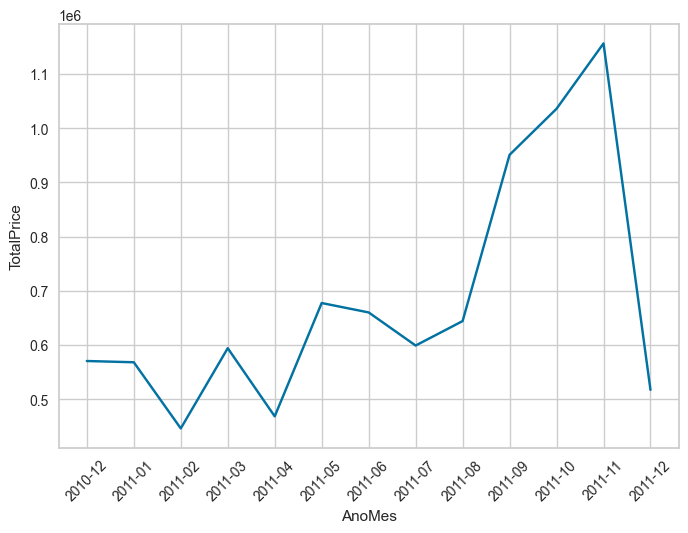

In [27]:
'''
Aqui percebe-se que há um aumento drástico nas vendas no período de agosto-novembro, com pico no mês de novembro
'''
df['AnoMes'] = df.InvoiceDate.astype('string').apply(lambda x:x[0:7])

sns.lineplot(df.groupby('AnoMes').TotalPrice.sum());
plt.xticks(ticks = range(0,13),
           labels = df['AnoMes'].sort_values().unique(),
           rotation = 45);

In [28]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Frequency', 'Recency',
       'TotalPrice', 'MeanPrice', 'AnoMes'],
      dtype='object')

In [29]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Frequency,Recency,TotalPrice,MeanPrice,AnoMes
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,34,371,15.30,18.15,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,34,371,22.00,18.15,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15,2010-12


In [30]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Frequency,Recency,TotalPrice,MeanPrice,AnoMes
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,34,371,15.30,18.15,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,34,371,22.00,18.15,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,34,371,20.34,18.15,2010-12


Tratamento de outliers

<Axes: xlabel='Quantity', ylabel='UnitPrice'>

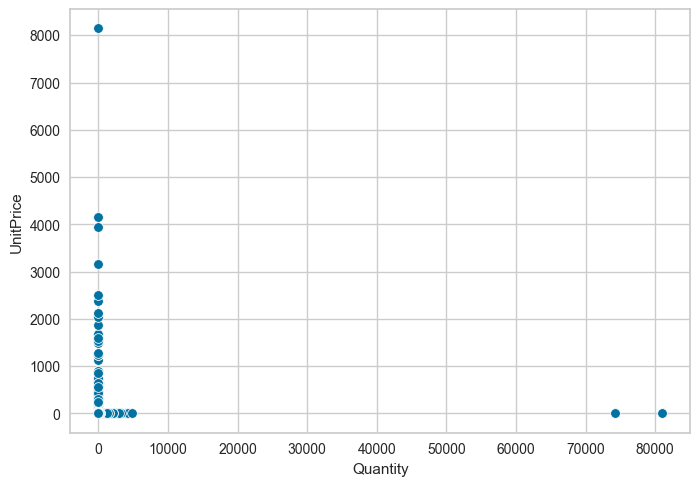

In [31]:
sns.scatterplot(data = df, x = 'Quantity', y = 'UnitPrice')

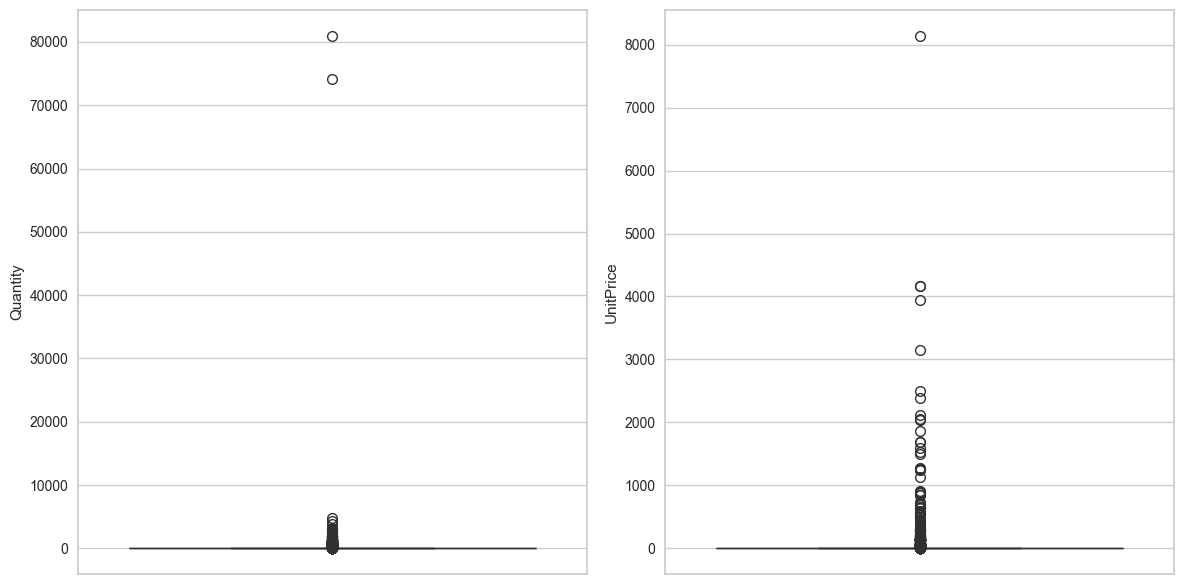

In [32]:
'''
Da pra perceber que os outliers estão tão gritantes que fica até dificil de visualizá-los, já vou retirar 5% dos dados superiores pra
ver se fica mais facil analisar, começando por UnitPrice
'''
fig, axes = plt.subplots(ncols = 2, figsize=(12, 6))
sns.boxplot(data = df['Quantity'], ax = axes[0])
sns.boxplot(data = df['UnitPrice'], ax = axes[1])
plt.tight_layout()


In [33]:
def remove_outlier_sup_inf(df : pd.DataFrame, coluna : str, sup : float, inf = 0):
  sup = sup / 100
  inf = inf / 100
  lim_inf = np.quantile(df[f'{coluna}'], 0 + inf)
  lim_sup = np.quantile(df[f'{coluna}'], 1 - sup)

  df = df[(df[f'{coluna}'] > lim_inf) & (df[f'{coluna}'] < lim_sup)]
  return df

In [34]:
df = remove_outlier_sup_inf(df,'UnitPrice',5)

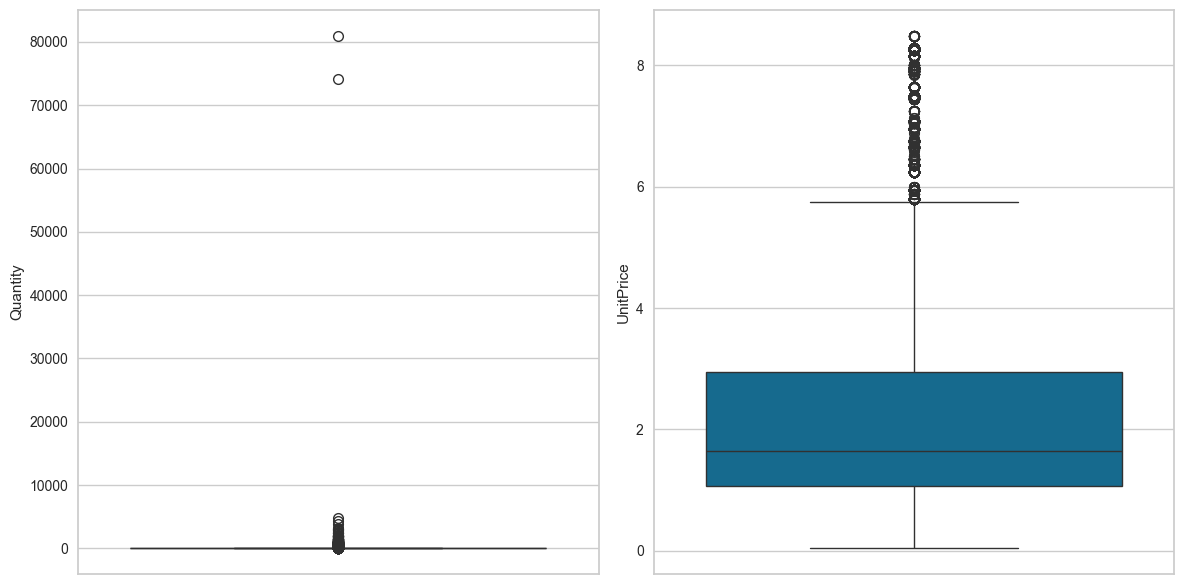

In [35]:
'''
Agora ta bem mais visualizável, agora irei retirar também os 5 superiores da coluna quantity
'''
fig, axes = plt.subplots(ncols = 2, figsize=(12, 6))
sns.boxplot(data = df['Quantity'], ax = axes[0])
sns.boxplot(data = df['UnitPrice'], ax = axes[1])
plt.tight_layout()

In [36]:
df = remove_outlier_sup_inf(df,'Quantity',5)

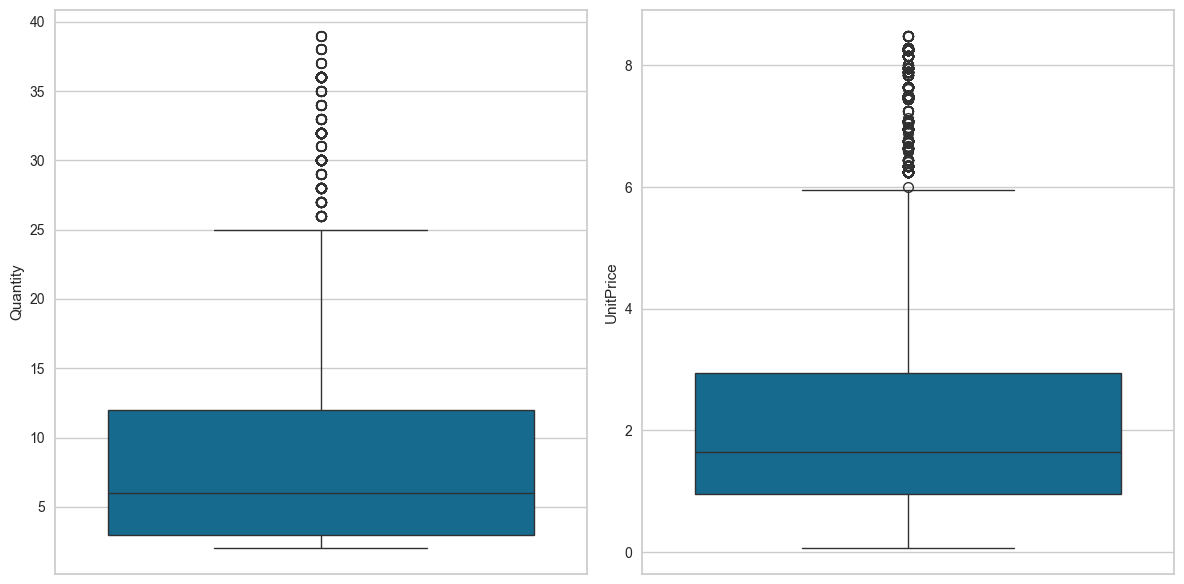

In [37]:
'''
Percebemos que ainda há existência de outliers, mas eles não são tão gritantes quanto os anteriores, então irei
'''
fig, axes = plt.subplots(ncols = 2, figsize=(12, 6))
sns.boxplot(data = df['Quantity'], ax = axes[0])
sns.boxplot(data = df['UnitPrice'], ax = axes[1])
plt.tight_layout()

<Axes: xlabel='Quantity', ylabel='UnitPrice'>

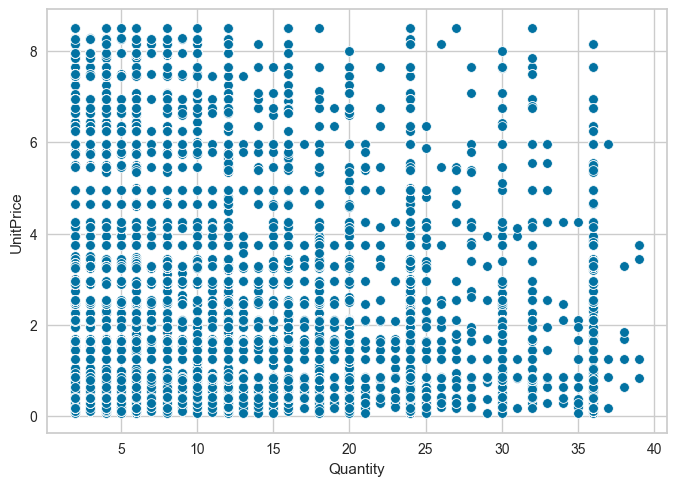

In [38]:
'''
 Ainda há presença de outliers, mas não são tão distantes quanto os presentes anteriormente,
 dessa forma, continuarei a analisar  com esses outliers, para também não ficar removendo
 grandes quantidades de dados (quanto mais dados pra analisar, melhor)
'''
sns.scatterplot(data = df, x = 'Quantity', y = 'UnitPrice')

In [39]:
#Com o tratamento de outliers, agora vou redefinir as métricas a serem analisadas
df = df.drop(columns = ['Frequency','MeanPrice','Recency'])

ultima_data = df.InvoiceDate.max()
ultima_compra = df.groupby('CustomerID').InvoiceDate.max().reset_index().rename(columns = {'InvoiceDate':'LastPurchase'})

df = df.merge(ultima_compra, how = 'left', on ='CustomerID')
df['Recency'] = df['LastPurchase'].apply(lambda x: (ultima_data - x).days)
df = df.drop(columns = 'LastPurchase')

agg_customer_invoiceNo = df.groupby(['CustomerID','InvoiceNo','InvoiceDate']).sum().reset_index()
qtdade_compras = agg_customer_invoiceNo.groupby('CustomerID').InvoiceNo.count().reset_index().rename(columns = {'InvoiceNo':'Frequency'})
df = df.merge(qtdade_compras, how = 'left', on ='CustomerID')

df['TotalPrice'] = df['UnitPrice']*df['Quantity']
df_mean_price = df.groupby('CustomerID').TotalPrice.mean().round(2).reset_index().rename(columns = {'TotalPrice':'MeanPrice'})
df = df.merge(df_mean_price, how = 'left', on ='CustomerID')

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,AnoMes,Recency,Frequency,MeanPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,371,34,16.55
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,371,34,16.55
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,371,34,16.55
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,371,34,16.55
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,371,34,16.55


In [41]:
df = df.drop(columns = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','Country','TotalPrice','AnoMes'])#Vou dropar colunas que não são mais relevantes para a continuação do desenvolvimento

In [42]:
df.head() #Vou remover as "duplicatas" pra ficar com o dataframe final desejado

,CustomerID,Recency,Frequency,MeanPrice
0,17850.0,371,34,16.55
1,17850.0,371,34,16.55
2,17850.0,371,34,16.55
3,17850.0,371,34,16.55
4,17850.0,371,34,16.55


In [43]:
df = df.drop_duplicates().set_index('CustomerID')

In [44]:
df.head()

,Recency,Frequency,MeanPrice
CustomerID,,,
17850.0,371,34,16.55
13047.0,56,9,18.38
12583.0,2,15,27.10
14688.0,7,20,16.77
17809.0,15,6,49.26


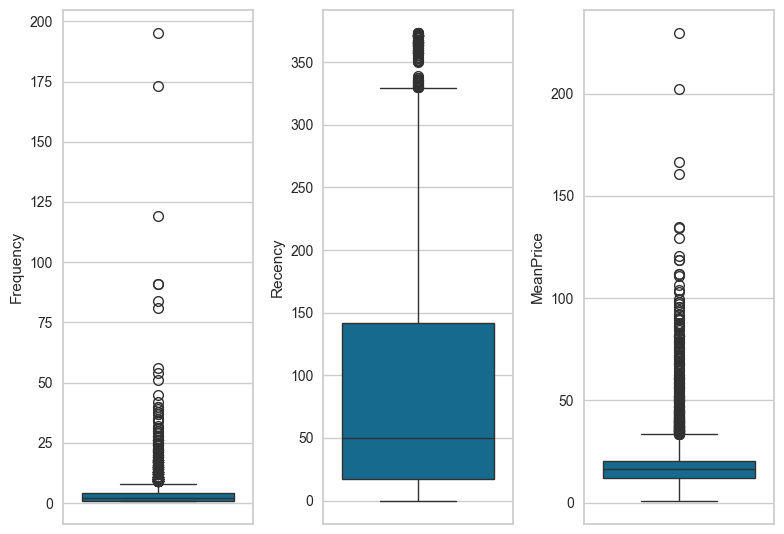

In [45]:
fig,axes = plt.subplots(ncols = 3)
sns.boxplot(df['Frequency'], ax = axes[0])
sns.boxplot(df['Recency'], ax = axes[1])
sns.boxplot(df['MeanPrice'], ax = axes[2])
plt.tight_layout()

In [46]:
df_less_outliers = df[(df['Frequency'] < 40) & (df['MeanPrice'] <= 100)]

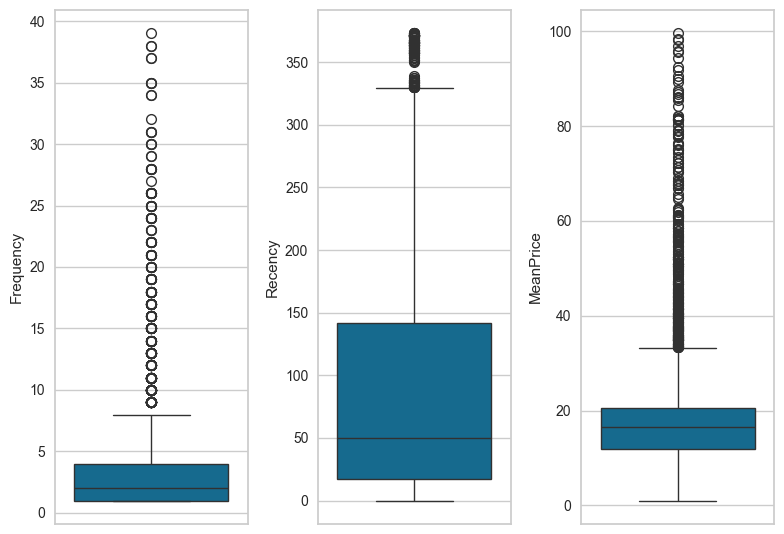

In [47]:
fig,axes = plt.subplots(ncols = 3)
sns.boxplot(df_less_outliers['Frequency'], ax = axes[0])
sns.boxplot(df_less_outliers['Recency'], ax = axes[1])
sns.boxplot(df_less_outliers['MeanPrice'], ax = axes[2])
plt.tight_layout()

In [48]:
PT = PowerTransformer()
df_scaled = PT.fit_transform(df_less_outliers)
df_scaled = pd.DataFrame(df_scaled, index = df_less_outliers.index, columns = df_less_outliers.columns)

In [49]:
px.scatter_3d(df_scaled,x ='Recency', y = 'Frequency' ,z = 'MeanPrice')

# Modeling

##Kmeans

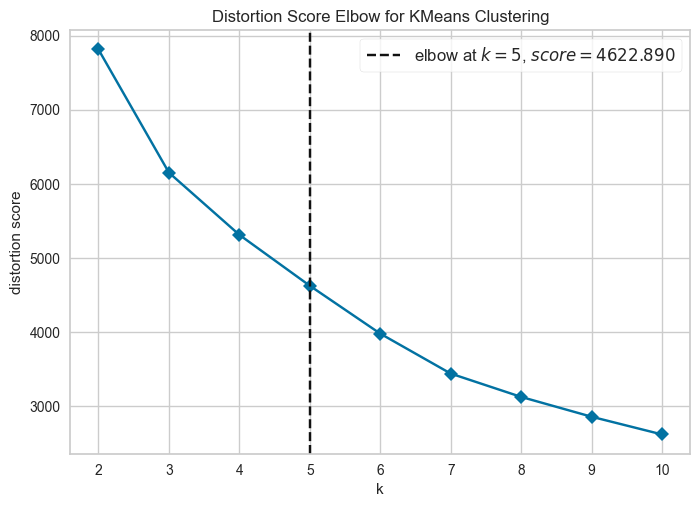

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init=10), timings=False)

In [50]:
kelbow_visualizer(KMeans(n_init = 10), df_scaled, k=10, timings=False)

Analisando o gráfico, as linhas que ligam os pontos presentes entre 3 e 7 aparentam ter inclinações parecidas, logo são candidatos válidos a melhor quantidade de clusters

In [51]:
#Função para visualizar as métricas, vai ser usada posteriormente novamente
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_scaled.copy();

for k in range(2,11):
  model = KMeans(n_init = 10, n_clusters=k, random_state=0);
  labels = model.fit_predict(X);
  cluster_results_dict = {'k': k};
  cluster_results_dict['inertia'] = model.inertia_;
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels);
  cluster_metrics_results.append(cluster_results_dict);

df_kmeans = pd.DataFrame(cluster_metrics_results)
df_kmeans.set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,7814.812228,0.342161,1.164474,2501.968883
3,6151.157384,0.327889,1.129682,2152.320273
4,5310.700580,0.268715,1.225379,1881.283919
5,4622.824588,0.277026,1.158003,1775.433170
6,3975.685883,0.288511,1.055854,1786.667344
7,3436.310275,0.302410,0.976709,1831.079189
8,3121.215312,0.305510,0.990079,1787.503226
9,2853.438249,0.304630,0.985323,1759.229278
10,2613.099278,0.310595,0.988984,1749.689646


Baseado no dataframe, a quantidade de 3 clusters mostra-se a melhor opção, em segundo lugar ficou a quantidade de 4 clusters

In [52]:
kmeans_metrics = df_kmeans[df_kmeans['k'] == 3].drop(columns = 'k')

In [53]:
kmeans_metrics

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
1,6151.157384,0.327889,1.129682,2152.320273


In [54]:
kmeans = KMeans(3, n_init = 10)
kmeans_labels = kmeans.fit_predict(df_scaled)

In [55]:
px.scatter_3d(df_less_outliers,x ='Recency', y = 'Frequency' ,z = 'MeanPrice', color=kmeans_labels.astype(str), template='plotly_dark')

##Agglomerative Clustering

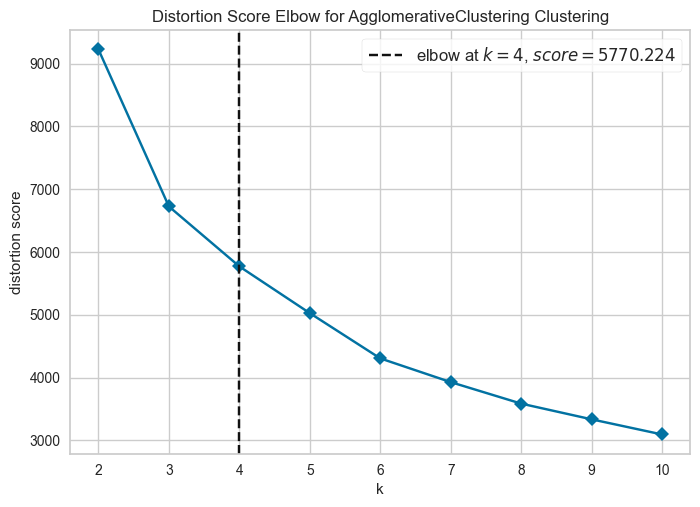

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [56]:
kelbow_visualizer(AgglomerativeClustering(), df_scaled, k=10, timings=False)

Baseado nessa métrica, os valores de 3, 4, 5, 6 seriam bons valores, vou olhar também as outras métricas

In [57]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

df_hierarchical = pd.DataFrame(cluster_metrics_results)
df_hierarchical.set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.251869,1.274992,1482.138988
3,0.287793,1.227656,1791.070870
4,0.255636,1.181989,1620.888757
5,0.227061,1.176982,1549.553355
6,0.264474,1.118849,1586.097044
7,0.255492,1.174257,1515.316696
8,0.263381,1.077351,1479.353328
9,0.236148,1.132118,1430.292135
10,0.239216,1.130298,1406.066657


Pelo panorama geral do dataframe, o valor de 3 clusters aparenta ser o mais adequado, em segundo lugar ficaria o de 4 clusters

In [58]:
hierarchical_metrics = df_hierarchical[df_hierarchical['k'] == 3].drop(columns = 'k')

In [59]:
hclust = AgglomerativeClustering(n_clusters=3)
hclust_labels = hclust.fit_predict(df_scaled)

In [60]:
px.scatter_3d(df_less_outliers,x ='Recency', y = 'Frequency' ,z = 'MeanPrice', color=hclust_labels.astype(str), template='plotly_dark')

##DBSCAN

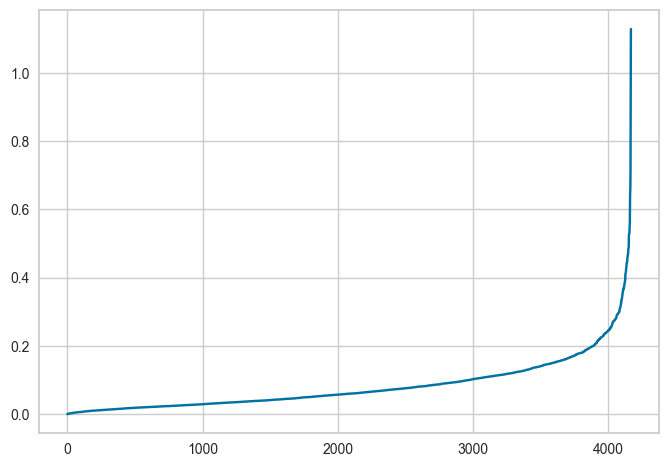

In [61]:
X = df_scaled.copy()
# Gráfico para encontrar o melhor valor para eps, semelhante ao kelbow (pegar o joelho)
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nn_model.kneighbors(X)
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.show()

In [62]:
# Train DBSCAN
model = DBSCAN(eps= 0.21)
dbscan_labels = model.fit_predict(X)

In [63]:
# Train DBSCAN (function)
dbscan_labels = dbscan(X)[1]

In [64]:
px.scatter_3d(df_scaled,x ='Recency', y = 'Frequency' ,z = 'MeanPrice', color=dbscan_labels.astype(str), template='plotly_dark')

In [65]:
#Vou fazer um tratamento para remover os outliers, classificados como -1
df_dbscan_labeled = df_scaled.copy()
df_dbscan_labeled['Labels'] = dbscan_labels
df_dbscan_no_outliers = df_dbscan_labeled[df_dbscan_labeled['Labels'] != -1]
labels = df_dbscan_no_outliers.Labels.values

In [66]:
px.scatter_3d(df_dbscan_no_outliers,x ='Recency', y = 'Frequency' ,z = 'MeanPrice', color=labels.astype(str), template='plotly_dark')

In [67]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

X = df_dbscan_no_outliers.copy()
cluster_results_dict = {}
for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
cluster_metrics_results.append(cluster_results_dict)

dbscan_metrics = pd.DataFrame(cluster_metrics_results)

## Comparação dos resultados e escolha do modelo

In [68]:
kmeans_metrics = kmeans_metrics.merge(hierarchical_metrics, how = 'outer')
total_metrics = kmeans_metrics.merge(dbscan_metrics, how = 'outer')
total_metrics['Modelo'] = ['KMeans','hierarchical','DBSCAN']
total_metrics = total_metrics.set_index('Modelo')
total_metrics.style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
Modelo,,,,
KMeans,nan,0.287793,1.227656,1791.070870
hierarchical,6151.157384,0.327889,1.129682,2152.320273
DBSCAN,nan,0.343330,1.349234,2034.278708


Analisando as métricas do dataframe, percebe-se que o melhor algoritmo é o DBSCAN

#Análise dos Clusters e sugestão de ações

##Análise dos clusters

Assim, temos o dataframe final como sendo:

In [69]:
df_dbscan_labeled = df_scaled.copy()
df_dbscan_labeled['Labels'] = dbscan_labels
df_dbscan_labeled = df_dbscan_labeled[df_dbscan_labeled['Labels'] != -1]

Vou fazer a média de cada parâmetro por label pra poder analisar

In [70]:
df_mean = df_dbscan_labeled.copy().groupby('Labels').mean()

In [71]:
df_mean

,Recency,Frequency,MeanPrice
Labels,,,
0,-0.534579,0.968776,0.050186
1,0.625436,-1.144854,-0.064081
2,0.104259,-0.160351,-0.049014


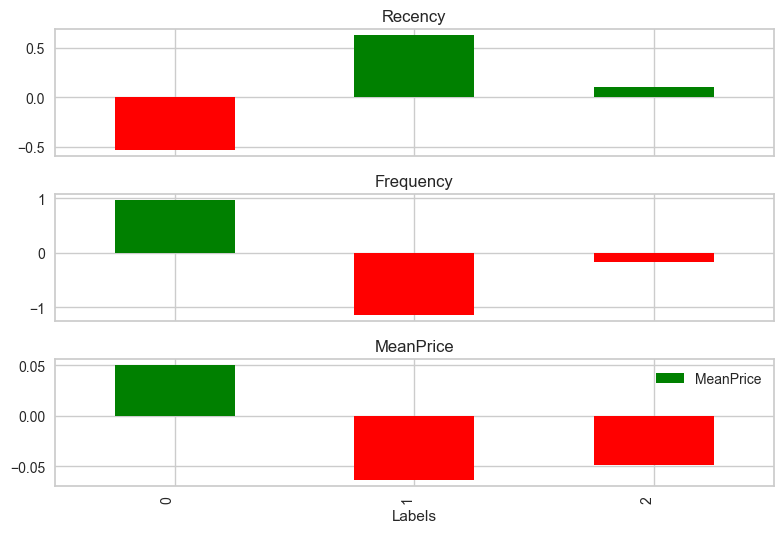

In [72]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex = True)
i = 0
for coluna in df_mean.columns:
  colors = ['green' if l > 0 else 'red' for l in df_mean[f'{coluna}']]
  df_mean[f'{coluna}'].T.plot.bar(ax = axes[i], title = coluna, color = colors)
  i += 1
plt.xticks(rotation=90, ha='right')
plt.legend(frameon=False)
plt.tight_layout()
plt.show();

No cluster 0 encontra-se clientes cujo valor médio de compra e frequência de compra são mais elevados em comparação com indivíduos de outros clusters, além disso, possuem uma baixa recência.

Já no cluster 1, são clientes que compram produtos mais baratos, com uma baixa frequência e que fizeram a sua última compra há muito tempo.

No cluster 2, estão presentes clientes cujo preço médio também é relativamente pequeno, mas sua frequência é aceitável, ainda que menor que os do cluster 0. A recência é mais elevada que a do cluster 0, mas bem menor que a do cluster 1  

A partir da análise dos clusters criados, temos que:

Indivíduos do cluster 0 são os mais valiosos para a empresa, visto que são os que compram com maior frequência, fazem compras mais caras, e faz pouco tempo que fizeram a ultima compra, ou seja, são clientes fiéis.

Os indivíduos do cluster 1 são indivíduos que provavelmente fizeram alguma compra qualquer na loja e nunca mais pediram nada. Provavelmente são indivíduos que não gostaram do serviço prestado.

Por fim, os indivíduos do cluster 2 são indivíduos que, embora comprem produtos baratos, compram com uma certa frequência, mas faz um certo tempo que já não compram mais.


##Sugestão de ações


Assim, para os indivíduos do cluster 0 é valido ter uma atenção redobrada quanto a características que possam levá-los a deixar de usar os serviços da empresa, visto que são bem fiéis. Também é valido aplicar promoções a eles, a fim de mantê-los satisfeitos com o serviço da empresa

Já para os indivíduos do cluster 1, é valido fazer uma pesquisa de satisfação do cliente, para entender o porquê deles estarem a tanto tempo sem pedir produtos, sendo importantes para descobrir pontos fracos do serviço prestado.

Por ultimo, para os indivíduos do cluster 2, faz-se necessário um estudo mais aprofundado sobre as características deles, a fim de aproximá-los do padrão do cluster 0 e afastá-los do padrão do cluster 1.